In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
train = pd.read_csv("../input/nlp-getting-started/train.csv")

In [3]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
train.size, test.size

(38065, 13052)

## Inspect The Dataset

### Remove duplicated data

#### duplicated row exists

In [6]:
duplicated_nums = train.duplicated().sum()

In [7]:
# exists duplicated rows we remove all.
if duplicated_nums: train = train.drop_duplicates().reset_index(drop=True)

### peek the distribution of targets from our training data
- Ensure not exists **inbalance data problem**
- make sure **class balance**
- 因為是 binary classification problem，只需要檢查 `0、1` 的分布。
- 結果證明 :
    - disaster : `57%`
    - non-disaster : `42%`

In [8]:
train['target'].value_counts().apply(lambda x: x / train['target'].count())

0    0.57034
1    0.42966
Name: target, dtype: float64

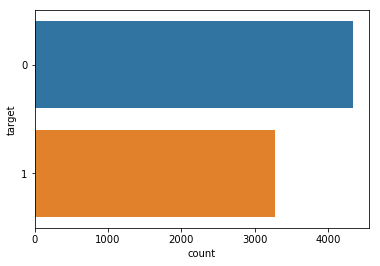

In [9]:
sns.countplot(y=train.target)

### peek NAN data

In [10]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

### peek Keywords 

#### sets of keywords differs from train and test

In [12]:
# Check number of unique keywords, and whether they are the same for train and test sets
print(train.keyword.nunique(), test.keyword.nunique())
print(set(train.keyword.unique()) - set(test.keyword.unique()))

221 221
set()


Train and test have the same set of keywords

#### Find the most keyword refered to

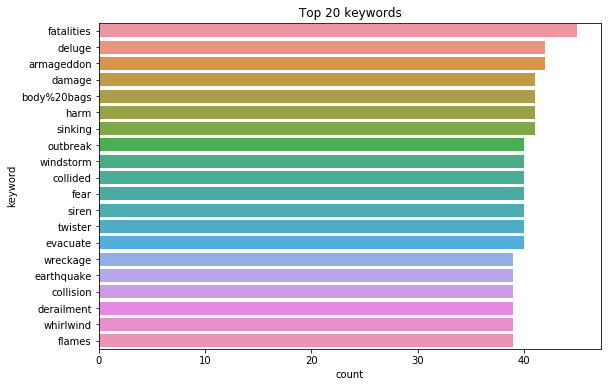

In [13]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order=train.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

#### The difference of Top keywords between disaster tweets and non-disaster tweets

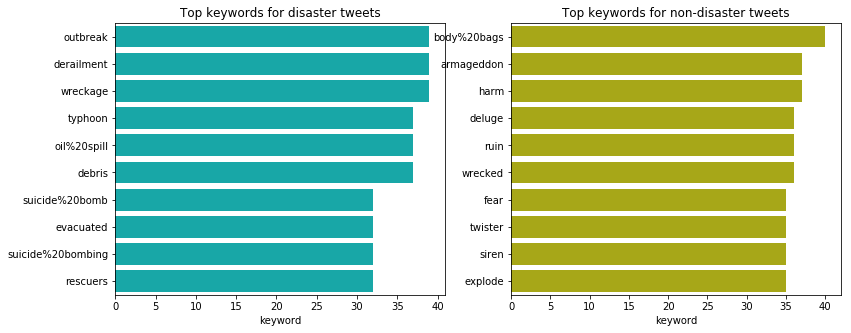

In [14]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

#### Keywords with highest percentage of disaster tweets
- 對資料表做groupby(keyword).mean()的意義是找出每個keyword偏好是disaster或是non-disaster
- 因此range介於[0,1]

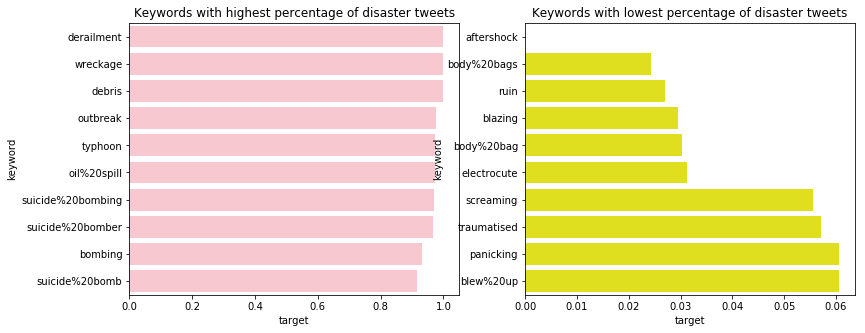

In [15]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest percentage of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest percentage of disaster tweets')
plt.show()

例如，keyword為`aftershock`時就不會存在任何disaster的文章。

### Peek loction

#### sets of locations differs from train and test

In [16]:
# Check number of unique locations in train and test
print(train.location.nunique(), test.location.nunique())
print('location in train but not in test: ', len(set(train.location.unique()) - set(test.location.unique())))
print('location in test but not in train: ', len(set(test.location.unique()) - set(train.location.unique())))
print('location appears in test and train: ', len(set(test.location.unique()) & set(train.location.unique())))

3341 1602
location in train but not in test:  2919
location in test but not in train:  1180
location appears in test and train:  423


- trainset 有 3341 種 location
- testset 有 1602 種 location
- testset 具有 1180 個 location 是在 trainset 中沒看過的資料
- 有 423 種 location 同時出現在 trainset and testset

#### Find the most location refered to

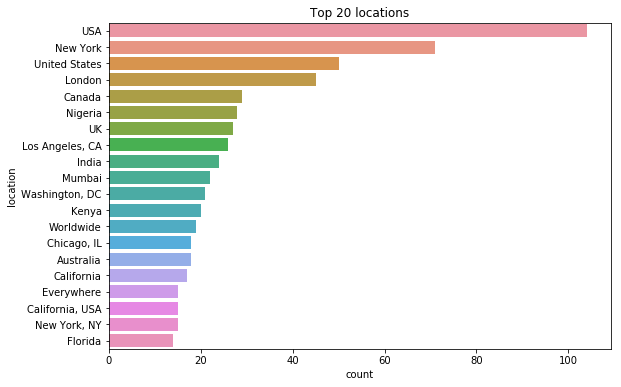

In [17]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:20].index)
plt.title('Top 20 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

#### location with highest percentage of disaster tweets

top_loc:  ['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria', 'UK', 'Los Angeles, CA', 'India', 'Mumbai', 'Washington, DC', 'Kenya', 'Worldwide', 'Chicago, IL', 'Australia', 'California', 'Everywhere', 'California, USA', 'New York, NY', 'Florida', 'San Francisco', 'United Kingdom', 'Los Angeles', 'Washington, D.C.', 'Indonesia', 'NYC', 'Ireland', 'Toronto', 'Chicago', 'San Francisco, CA', 'Seattle', 'Earth', 'Atlanta, GA', 'ss', 'New York City', 'Sacramento, CA', 'London, UK', 'London, England', 'Texas']


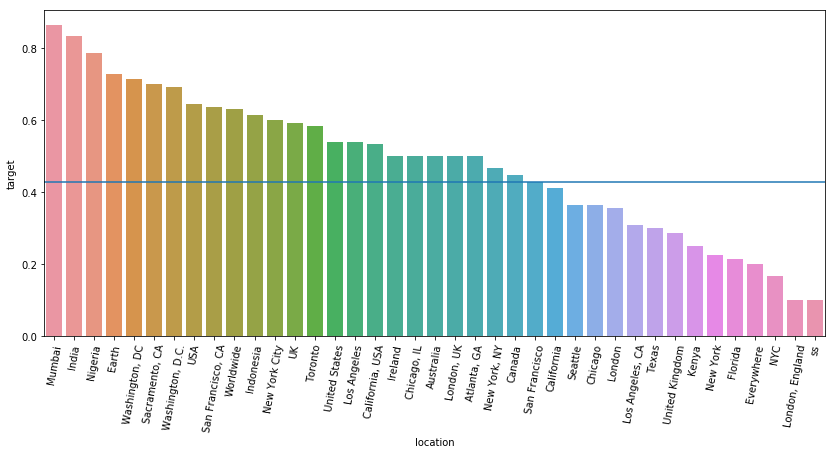

In [18]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
print('top_loc: ', top_loc)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

- The top 3 locations with highest % of disaster tweets are Mumbai, Inida, and Nigeria. 
- As the location data is not clean, we see some interesting cases, such as 'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average. We try to clean up the location and see if there is any difference:

### peek the correlation matrix to consider which feature suppose to  be important

#### keyword、location frequency 

In [19]:
unique_keys, unique_locations = train['keyword'].value_counts(normalize=True), train['location'].value_counts(normalize=True)
unique_keys.head(), unique_locations.head()

(fatalities     0.005959
 deluge         0.005561
 armageddon     0.005561
 damage         0.005429
 body%20bags    0.005429
 Name: keyword, dtype: float64, USA              0.020472
 New York         0.013976
 United States    0.009843
 London           0.008858
 Canada           0.005709
 Name: location, dtype: float64)

#### keyword、location index 

In [20]:
# train['keyword_freq'] = train['keyword'].apply(lambda x: unique_keys[x] if x in unique_keys else 0)
# train['location_freq'] = train['location'].apply(lambda x: unique_locations[x] if x in unique_locations else 0)

In [21]:
# unique_keys_index = pd.Series(np.arange(len(unique_keys), 0, -1), index=unique_keys.index)
# unique_locations_index = pd.Series(np.arange(len(unique_locations), 0, -1), index=unique_locations.index)

In [22]:
# train['keyword_index'] = train['keyword'].apply(lambda x: unique_keys_index[x] if x in unique_keys else 0)
# train['location_index'] = train['location'].apply(lambda x: unique_locations_index[x] if x in unique_locations else 0)

#### replace non to zero

In [23]:
# train_fill_zero = train.fillna(0)

In [24]:
# train_fill_zero.head()

In [25]:
# corr = train_fill_zero[['id', 'keyword_freq', 'location_freq', 'target']].corr()
# sns.heatmap(corr, annot=True)


* `id、keyword、location` 對於 `target` 的影響力普遍不高。
* `keyword frequency` 對於 `target` 的影響力最小。
* `Id` 對於 `target` 的影響力最大。

> 因此我們試著從 `text` 找出關聯性。

## Peek Text

### Clean up Text Column

* Making a 'clean' text column, removing links and unnecessary white spaces
* Creating separate columns containing lists of hashtags, mentions, and links

In [26]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


### hashtags, mentions, links

In [27]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):   
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)  
    return df
    
train = process_text(train)
test = process_text(test)

In [28]:
train.head()

,id,keyword,location,text,target,text_clean,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no


In [29]:
train.shape,test.shape

((7613, 9), (3263, 8))

### Create statistics from texts

In [30]:
from wordcloud import STOPWORDS
import string
def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 18) (3263, 17)


In [31]:
set(train.columns)-set(test.columns)

{'target'}

### Correlation Matrix

In [32]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

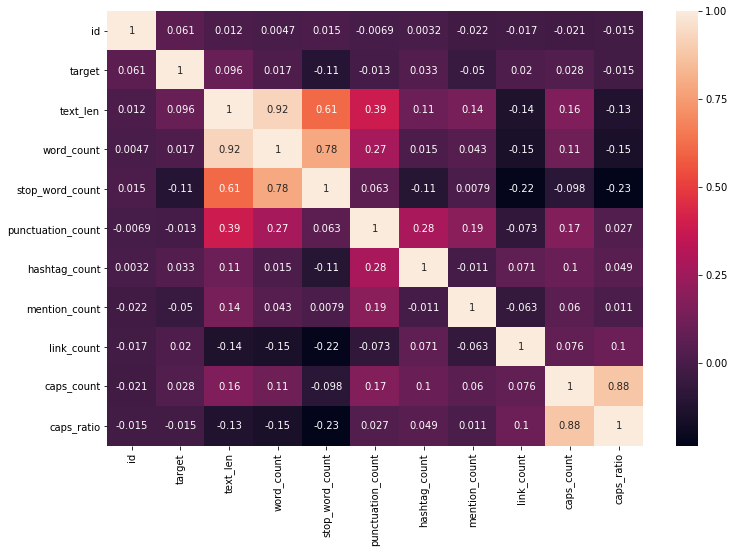

In [33]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True)

All of the statistics have very low correlation with the target variable

### Most frequent words and bigrams

In [34]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)

#### Unigrams

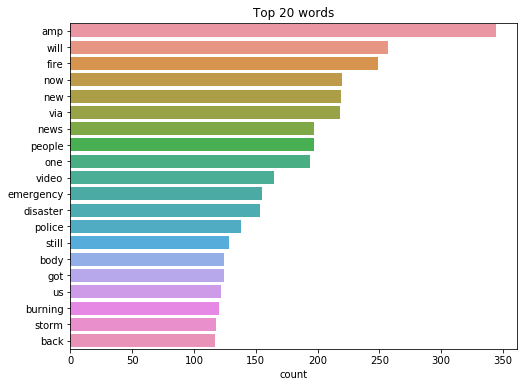

In [35]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index')
df_word_freq.columns=['count']
top20w = df_word_freq.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

We try to distinguish disaster and non-disaster tweets:

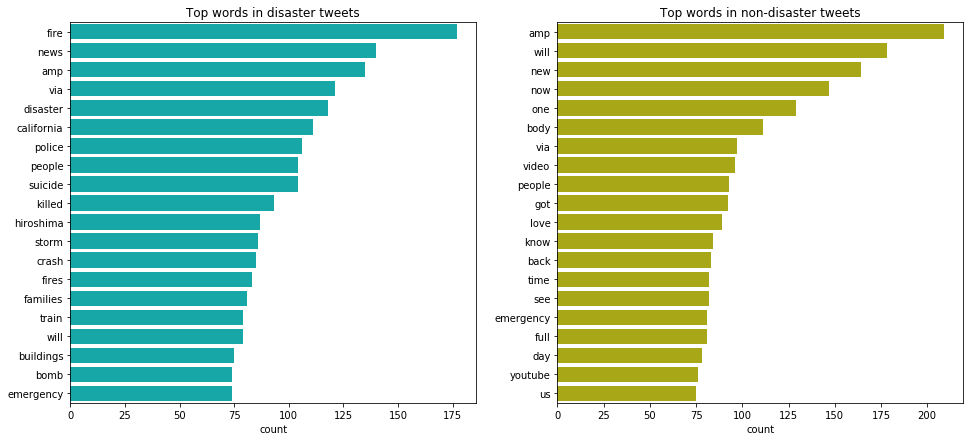

In [36]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index')
df_d.columns = ['count']
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')

plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index')
df_nd.columns = ['count']
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

Findings:

- Top two words in disaster tweets: 'fire' and 'news', don't make the top 20 on unreal disaster tweets.
- Words are more specific for real disaster tweets (e.g. 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb').

#### Bigrams

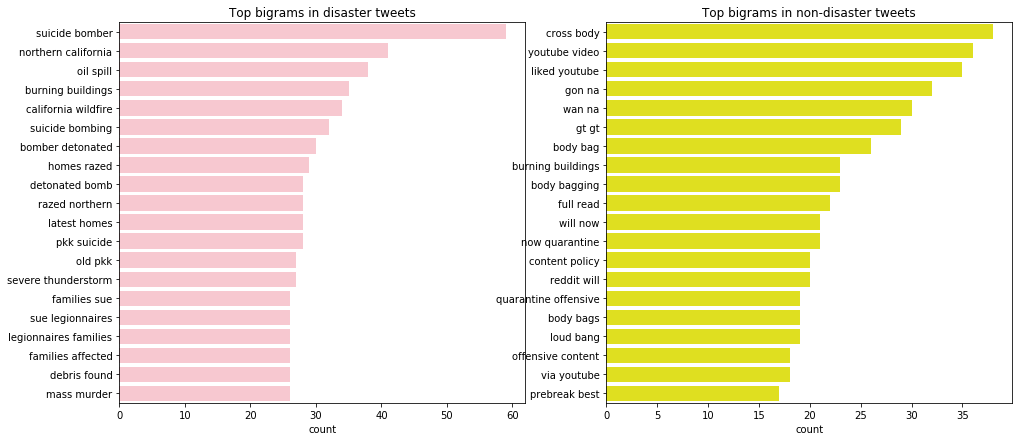

In [37]:
from nltk import bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index')
bgdf_d.columns = ['count']
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index')
bgdf_nd.columns = ['count']
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

Findings:

- Most top bigrams in disaster tweets show certain kinds of catestrophe (e.g. suicide bomber, oil spill, california wildfire); for non-disaster tweets, only 'burning buildings' as top bigram look like a disaster;
- Top bigrams in disaster tweets have a more casual tone;
'youtube' appears in three of the twenty bigrams for non-disaster tweets; none in disaster tweets

### Encoding and Vectorizers

As part of feature generation, we will:

- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [38]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features], train['target'])
train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

In [39]:
train['keyword_target'][:5], train['location_target'][:5]

(0    0.688525
 1    0.688525
 2    0.688525
 3    0.688525
 4    0.688525
 Name: keyword_target, dtype: float64, 0    0.424398
 1    0.424398
 2    0.424398
 3    0.424398
 4    0.424398
 Name: location_target, dtype: float64)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())

print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


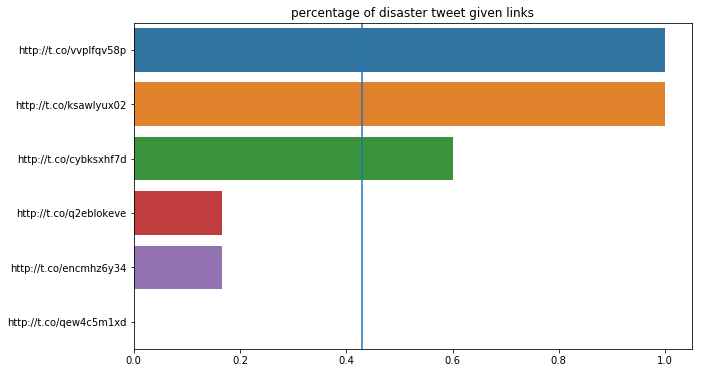

In [41]:
_ = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=_, y=_.index)
plt.axvline(np.mean(train.target))
plt.title('percentage of disaster tweet given links')
plt.show()

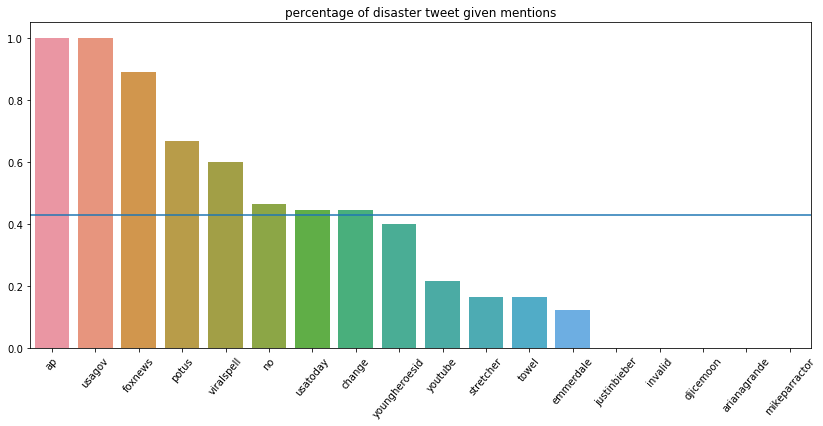

In [42]:
_ = (X_train_men.transpose().dot(train['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=_.index, y=_)
plt.axhline(np.mean(train.target))
plt.title('percentage of disaster tweet given mentions')
plt.xticks(rotation = 50)
plt.show()

In [43]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 100% of Tweets are disasters: 
['yyc', 'japan', 'science', 'rohingya', 'okwx', 'newyork', 'myanmar', 'mumbai', 'wx', 'libya', 'india', 'socialnews', 'hiroshima', 'hailstorm', 'earthquake', 'disaster', 'breaking', 'bestnaijamade', 'antioch', 'africa', 'sittwe', 'mh370', 'abstorm', 'worldnews', 'wildfire', 'wildfires']
Total: 26
Hashtags with which 0% of Tweets are disasters: 
['np', 'summerfate', 'job', 'jobs', 'animalrescue', 'kindle', 'fashion', 'bb17', 'dnb', 'ices', 'beyhive', 'edm', 'technology', 'dubstep', 'trapmusic', 'military', 'dance', 'soundcloud']
Total: 18


In [44]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [45]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1842) (3263, 1841)


In [46]:
train.head()

,id,keyword,location,text,target,text_clean,hashtags,mentions,links,text_len,...,û_,ûª,ûªs,ûªt,ûªve,ûï,ûïwhen,ûïwhen saw,ûò,ûó
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict by simple SVM model

In [47]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()
SVM = svm.SVC()
X_train = train.drop(features_to_drop + ['target'], axis=1)
X_test = test.drop(features_to_drop, axis=1)
y_train = train.target

pipeline = Pipeline([('scale',scaler), ('svm', SVM)])
pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sample_submission.copy()
submit.target = y_test
submit.to_csv('submit_svm.csv',index=False)

#### Results

In [48]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.8777


In [49]:
# F-1 score
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f-1 score: 0.8475


In [50]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,4095,247
1,684,2587


#### Evaluation

##### Cross validation

In [51]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.769


##### visualization

In order to project onto 2-D plot, we use PCA as dimension reduction approach and train a linear kernel SVM 

In [52]:
from sklearn.decomposition import PCA
def visualization(X_train, y_train):
    pca = PCA(n_components=2).fit(X_train)
    pca_2d = pca.transform(X_train)
    svmClassifier_2d = svm.LinearSVC(random_state=111).fit(pca_2d, y_train)
    for i in range(0, pca_2d.shape[0]):
        if y_train[i] == 0:
            c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r', s=50,marker='+')
        else:
            c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g', s=50,marker='o')
    
    plt.legend([c1, c2], ['non-disaster', 'disaster'])
    x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:, 0].max() + 1
    y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),   np.arange(y_min, y_max, .01))
    Z = svmClassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z)
    plt.title('Support Vector Machine Decision Surface')
    plt.axis('off')
    plt.show()

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


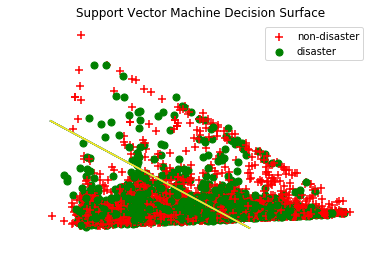

In [53]:
visualization(X_train, y_train)

### Predict by simple kNN model

In [54]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()
KNN = RadiusNeighborsClassifier(radius=1.0,outlier_label=0)
X_train = train.drop(features_to_drop + ['target'], axis=1)
X_test = test.drop(features_to_drop, axis=1)
y_train = train.target

pipeline = Pipeline([('scale',scaler), ('knn', KNN)])
pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sample_submission.copy()
submit.target = y_test
submit.to_csv('submit_knn.csv',index=False)

#### Results

In [55]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.9676


In [56]:
# F-1 score
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f-1 score: 0.9612


In [57]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,4310,32
1,215,3056


#### Evaluation

##### Cross validation

In [58]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.392


##### visualization

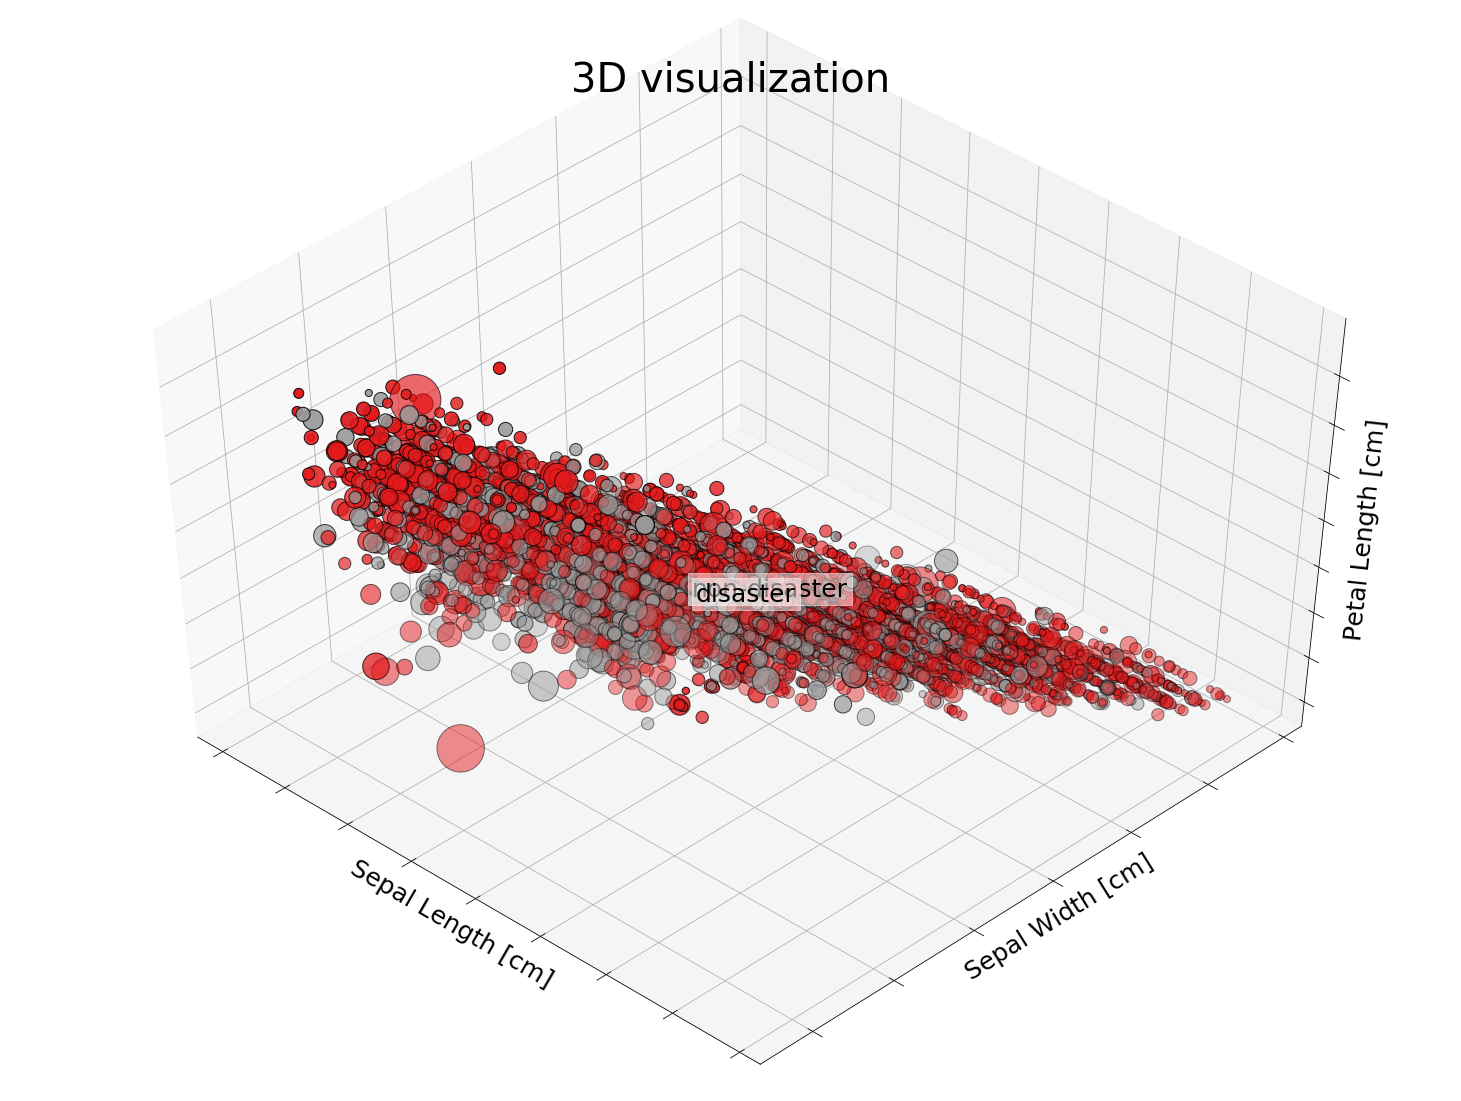

In [59]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(20, 15))
ax = Axes3D(fig, elev=48, azim=134)
ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], X_train.iloc[:, 2], c=y_train,
           cmap=plt.cm.Set1, edgecolor='k',s = X_train.iloc[:, 3]*50)
for name, label in [('non-disaster', 0), ('disaster', 1)]:
    ax.text3D(X_train[y_train == label].iloc[:, 0].mean(),
              X_train[y_train == label].iloc[:, 1].mean(),
              X_train[y_train == label].iloc[:, 2].mean(),
              name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),size=25)

ax.set_title("3D visualization", fontsize=40)
ax.set_xlabel("Sepal Length [cm]", fontsize=25)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Sepal Width [cm]", fontsize=25)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Petal Length [cm]", fontsize=25)
ax.w_zaxis.set_ticklabels([])

plt.show()

### Using Word2vec As Word Representation

In [60]:
import gensim
word2vec_bin = "../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin"

C:\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as 

### load word embedding generated from word2vec

In [61]:
def load_w2v(path):
    try:
        model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
        return model
    except:
        assert('fail to load word2vec file with gensim.')
    return None

In [62]:
vocabulary = load_w2v(word2vec_bin)

### peek length of text sequence 

#### find maximum and minimum

- 取得文章長度的範圍，其目的是:
    - 將 outlier 的資料去除。
    - 方便定義 `np.array` 的最大長度。

In [63]:
sequence_length = list(map(lambda x: len(x), train['text']))
min(sequence_length), max(sequence_length)

(7, 157)

#### show the distribution of text length

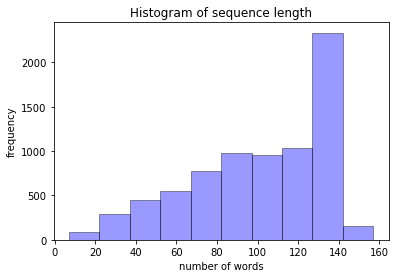

In [64]:
sns.distplot(sequence_length, hist=True, kde=False, 
             bins=10, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histogram of sequence length')
plt.xlabel('number of words')
plt.ylabel('frequency')

In [65]:
assert train['id'].size == train['id'].count() == train['id'].nunique()

Note : `count()` 含有null的筆數，`size` 不包含null的筆數。

### peek text where target is equal to 1

In [66]:
all_disaster_text = train[train['target']==1]['text']

In [67]:
all_disaster_text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

### Convert text to document representation
1. 若一則text有 128 個字，dimension of word representatoion is 300-d，則 document representation 為平均所有 128 words 之 300-d 的向量。

#### average from all word vectors

In [68]:
train_content_w2v = [np.mean(np.stack([vocabulary[word.lower()] if word.lower() in vocabulary else np.zeros(300) for word in sequence], axis=0),axis=0) for sequence in  train['text']]

`train_content_w2v` 保存所有文章的字向量平均值當成document representation 。

In [69]:
assert train['text'].size == train['text'].count() == len(train_content_w2v)

## Using SVM 

In [70]:
from sklearn import svm
from sklearn.manifold import Isomap 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

### visualization function

In [71]:
def visualization(x, y, pred_y):
    X_iso = Isomap(n_neighbors=10).fit_transform(x)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.subplots_adjust(top=0.85)
    ax[0].scatter(X_iso[:, 0], X_iso[:, 1], c=pred_y)
    ax[0].set_title('Predicted labels')
    ax[1].scatter(X_iso[:, 0], X_iso[:, 1], c=y)
    ax[1].set_title('Actual Labels')
    fig.suptitle('Predicted versus actual labels', fontsize=14, fontweight='bold')
    plt.show()

In [72]:
def confusion_visualization(y, pred_y):
    confusion_matrix = pd.crosstab(y, pred_y,rownames=['Actual'], colnames=['Predicted'], margins=True)
    sns.heatmap(confusion_matrix, annot=True)
    print(classification_report(y, pred_y))
    print('accuracy : %.2f' % accuracy_score(y, pred_y))

### SVM function

In [73]:
def svm_model(x, y):
    clf = svm.SVC()
    clf.fit(x, y)
    pred_results = clf.predict(x)
    return pred_results

In [74]:
def cross_validation(x, y, fold=5):
    clf = svm.SVC()
    scores = cross_val_score(clf, x, y, cv=fold)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### only feed text as input to SVM

#### transpose text to pandas object

In [75]:
doc_reps = pd.DataFrame(np.column_stack(list(zip(*train_content_w2v))), columns=list(range(300)))

In [76]:
doc_reps.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.124410,0.097314,0.010482,0.075123,-0.025311,0.017014,-0.076393,-0.047632,-0.031984,0.025122,...,0.057214,-0.001199,-0.083106,0.058787,-0.027698,-0.111066,-0.082072,-0.022762,-0.089122,0.125050
1,-0.115647,0.072862,0.010572,0.094418,-0.010029,0.018483,-0.052361,-0.030800,-0.029310,0.011063,...,0.049252,-0.012384,-0.053366,0.061652,-0.047203,-0.109645,-0.052612,-0.015561,-0.088353,0.126136
2,-0.126525,0.095432,-0.004981,0.108007,-0.030738,0.027574,-0.069169,-0.024910,-0.037003,0.008534,...,0.055916,-0.028659,-0.078233,0.068396,-0.012332,-0.110558,-0.066461,-0.015632,-0.091911,0.132138
3,-0.096324,0.062378,0.017642,0.105538,-0.037788,0.036622,-0.053350,-0.058699,-0.028748,0.030134,...,0.075034,-0.032941,-0.109602,0.082662,-0.019984,-0.118712,-0.082334,-0.014044,-0.093908,0.125664
4,-0.152208,0.085056,0.000776,0.097820,-0.021529,-0.014012,-0.071601,-0.042815,-0.017808,0.020277,...,0.055112,0.028782,-0.079380,0.076531,-0.049630,-0.146140,-0.106433,-0.023497,-0.062249,0.126584


#### projection of all comment

##### projection function

In [77]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
def project_3d(result, labels):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['dim_0'], result['dim_1'], result['dim_2'],c=labels, cmap="Set2_r", s=60)
    # make simple, bare axis lines through space:
    xAxisLine = ((min(result['dim_0']), max(result['dim_0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['dim_1']), max(result['dim_1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['dim_2']), max(result['dim_2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("dim_0")
    ax.set_ylabel("dim_1")
    ax.set_zlabel("dim_2")
    ax.set_title("reduction on the document vector")

##### linear reduction

In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [79]:
pca.fit(doc_reps)
result = pd.DataFrame(pca.transform(doc_reps), columns=['dim_%i' % i for i in range(3)], index=doc_reps.index)

In [80]:
doc_reps['label']= pd.Categorical(train['target'])
labels = doc_reps['label'].cat.codes
doc_reps = doc_reps.drop('label', 1)

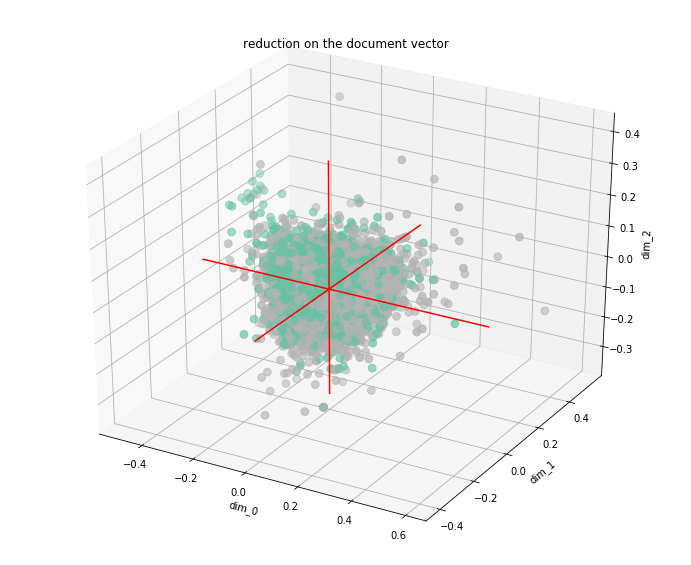

In [81]:
project_3d(result, labels)

##### non-linear reduction

In [82]:
isomap = Isomap(n_components=3, n_neighbors=10).fit_transform(doc_reps)

In [83]:
result = pd.DataFrame(isomap, columns=['dim_%i' % i for i in range(3)])

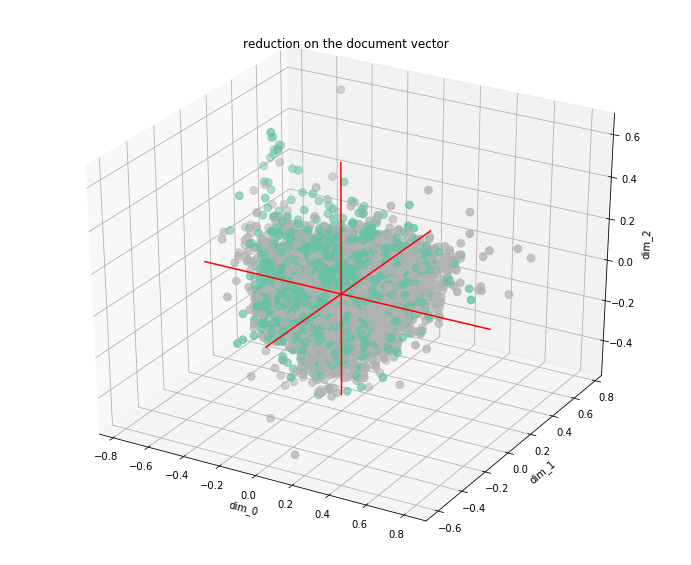

In [84]:
project_3d(result, labels)

#### Train SVM

In [85]:
train_X_only_text = doc_reps
train_Y = train['target']

In [86]:
predicted_only_text = svm_model(train_X_only_text, train_Y)

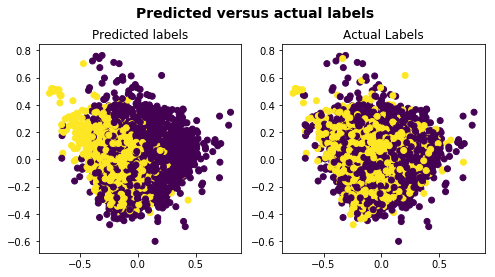

In [87]:
visualization(train_X_only_text, train_Y, predicted_only_text)

              precision    recall  f1-score   support

           0       0.66      0.80      0.73      4342
           1       0.64      0.46      0.53      3271

    accuracy                           0.66      7613
   macro avg       0.65      0.63      0.63      7613
weighted avg       0.65      0.66      0.64      7613

accuracy : 0.66


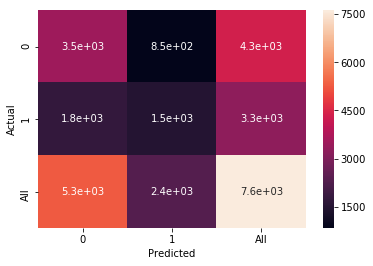

In [88]:
confusion_visualization(train_Y, predicted_only_text)

#### cross validation

In [89]:
cross_validation(train_X_only_text, train_Y)

[0.62311228 0.63361786 0.64478004 0.61826544 0.6609724 ]
Accuracy: 0.64 (+/- 0.03)


### filtering stop words

這裡發現的是，去除了stop word，其結果不變。

In [90]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\x2265\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
# Load stop words
stop_words = stopwords.words('english')
stop_words = set(stop_words)

In [92]:
train_content_w2v_filter = [np.mean(np.stack([vocabulary[word.lower()] if word.lower() in vocabulary else np.zeros(300) for word in sequence if word.lower() not in stop_words], axis=0),axis=0) for sequence in  train['text']]

In [93]:
predicted_only_text = svm_model(train_content_w2v_filter, train_Y)

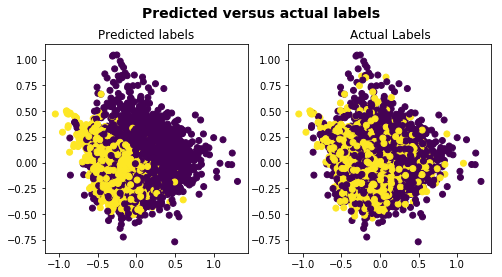

In [94]:
visualization(train_content_w2v_filter, train_Y, predicted_only_text)

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      4342
           1       0.62      0.52      0.57      3271

    accuracy                           0.66      7613
   macro avg       0.65      0.64      0.64      7613
weighted avg       0.66      0.66      0.65      7613

accuracy : 0.66


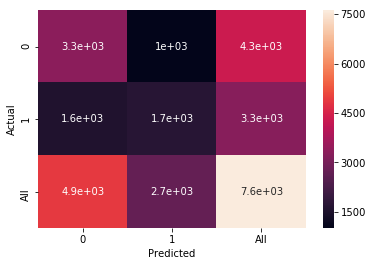

In [95]:
confusion_visualization(train_Y, predicted_only_text)

#### cross validation

In [96]:
cross_validation(train_content_w2v_filter, train_Y)

[0.61457649 0.64609324 0.65659882 0.61892247 0.6826544 ]
Accuracy: 0.64 (+/- 0.05)


### explore the ratio of stop words

#### 檢查各文章剩下的字之比例

In [97]:
remain_words_ratio =  train['text'].apply(lambda x: len((set(x.lower().split(' ')) - stop_words)) / len(x.split(' ')))

In [98]:
remain_words_ratio.head(), remain_words_ratio.mean()

(0    0.538462
 1    1.000000
 2    0.500000
 3    0.888889
 4    0.588235
 Name: text, dtype: float64, 0.7079532019362315)

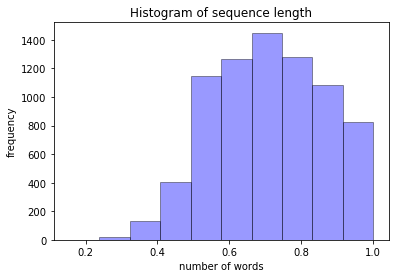

In [99]:
sns.distplot(remain_words_ratio, hist=True, kde=False, 
             bins=10, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histogram of sequence length')
plt.xlabel('number of words')
plt.ylabel('frequency')

**NOTE**
* 去除stopword對文章有一定的影響，平均每篇文章少了 `30%` 的字。
* 但是對於SVM模型的預測結果並沒有改變，因此可以說明造成的原因並非stopwords

#### contain number ?

In [114]:
digits = re.compile(r'^[-+]?[0-9]+[\.\,]*[0-9]+$')

In [115]:
train['digits'] = train['text'].apply(lambda x: any(digits.match(word) for word in x.split(' ')))

In [116]:
train['digits'].head()

0    False
1    False
2    False
3     True
4    False
Name: digits, dtype: bool

In [117]:
train['digits'].value_counts()

False    6922
True      691
Name: digits, dtype: int64

#### Country

In [118]:
nation = pd.read_csv("../input/hand-on-features/nation.csv", header=None)

In [119]:
nation = pd.concat([nation[0], nation[1], nation[2], nation[3]])

In [120]:
nation = nation.str.lower()

In [121]:
train['nation'] = train['text'].apply(lambda x: any(word.lower() in set(nation) for word in x.split(' ')))

In [122]:
train['nation'].head()

0     True
1     True
2     True
3     True
4    False
Name: nation, dtype: bool

In [123]:
train['nation'].value_counts()

True     4363
False    3250
Name: nation, dtype: int64

#### Not or No

In [124]:
train['not'] = train['text'].apply(lambda x: any(word.lower() in ['not','no','n\'t'] for word in x.split(' ')))

In [125]:
train['not'].head()

0    False
1    False
2     True
3    False
4    False
Name: not, dtype: bool

In [126]:
train['not'].value_counts()

False    7121
True      492
Name: not, dtype: int64

#### Symbolic

In [127]:
symbol = re.compile(r'^[A-Za-z]+[\?\!]+[A-Za-z]*$')

In [128]:
train['symbol'] = train['text'].apply(lambda x: any(symbol.match(word) for word in x.split(' ')))

In [129]:
train['symbol'].head()

0    False
1    False
2    False
3    False
4    False
Name: symbol, dtype: bool

In [130]:
train['symbol'].value_counts()

False    6581
True     1032
Name: symbol, dtype: int64

#### color

In [131]:
color = pd.read_csv("../input/hand-on-features/color.csv", header=None)

In [132]:
train['color'] = train['text'].apply(lambda x: any(word.lower() in color[0].values.tolist() for word in x.split(' ')))

In [133]:
train['color'].head()

0    False
1    False
2    False
3    False
4    False
Name: color, dtype: bool

In [134]:
train['color'].value_counts()

False    7364
True      249
Name: color, dtype: int64

#### dirty words

In [135]:
dirtyWords = pd.read_csv("../input/hand-on-features/dirtyWords.csv", header=None)

In [136]:
dirtyWords.head()

,0
0,anal
1,anus
2,arse
3,ass
4,ballsack


In [137]:
train['dirtyWords'] = train['text'].apply(lambda x: any(word.lower() in dirtyWords[0].values.tolist() for word in x.split(' ')))

In [138]:
train['dirtyWords'].value_counts()

False    7344
True      269
Name: dirtyWords, dtype: int64

#### Summarization

In [ ]:
additional_features = train.drop(['keyword','location','text'],axis=1)
additional_features.head()

,id,target,text_clean,hashtags,mentions,links,text_len,word_count,stop_word_count,punctuation_count,...,uppercase,seqlength,hashtag,persontag,digits,nation,not,symbol,color,dirtyWords
0,1,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,13,6,1,...,True,13,True,False,False,True,False,False,False,False
1,4,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,7,0,1,...,False,7,False,False,False,True,False,False,False,False
2,5,1,All residents asked to 'shelter in place' are ...,no,no,no,133,22,11,3,...,False,22,False,False,False,True,True,False,False,False
3,6,1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,8,1,2,...,False,9,True,False,True,True,False,False,False,False
4,7,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,16,7,2,...,False,17,True,False,False,False,False,False,False,False


In [ ]:
cross_validation(additional_features, train_Y)

In [ ]:
additional_features['keyword_freq'] = train_fill_zero['keyword_freq'] 
additional_features['location_freq'] = train_fill_zero['location_freq']
additional_features['keyword_index'] = train['keyword_index'] 
additional_features['location_index'] = train['location_index']

In [ ]:
corr = additional_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)

In [ ]:
additional_features.to_csv('discrete_features.csv', index=False)

## Enhance with additional features

1. preprocessing keyword、location
2. considering `Id`、`keyword`、`location`
3. considering `keyword`、`location`
4. considering `keyword` only
5. considering `location` only

In [ ]:
train_fill_zero_enhance = train_fill_zero.drop(['text', 'target'], axis=1)

In [ ]:
train_fill_zero_enhance.head()

In [ ]:
train_X = pd.concat([train_fill_zero_enhance[['id', 'keyword_freq', 'location_freq']], doc_reps.reindex(train.index)], axis=1)
train_Y = train['target']

In [ ]:
train_X.head()

In [ ]:
predicted = svm_model(train_X, train_Y)

In [ ]:
visualization(train_X, train_Y, predicted)

In [ ]:
confusion_visualization(train_Y, predicted)

### 這裡判斷是 Id 造成的降維不均，將 Id 去除

In [ ]:
train_X_without_id = train_X.drop(['id'], axis=1)

In [ ]:
train_X_without_id.head()

In [ ]:
predicted_without_id = svm_model(train_X_without_id, train_Y)

In [ ]:
visualization(train_X_without_id, train_Y, predicted_without_id)

In [ ]:
confusion_visualization(train_Y, predicted_without_id)

* 這裡證明了`Id` 能讓準確率上升。
* 必須證明出`Id` 與 `target` 是有關係的。

### 延伸，將 Id 去除，加入離散features

In [ ]:
train_X_without_id_extend = pd.concat([train_X_without_id, train[['uppercase', 'seqlength', 'hashtag', 'persontag', 'digits']]],axis=1)

In [ ]:
train_X_without_id_extend.head()

In [ ]:
predicted_without_id_extend = svm_model(train_X_without_id_extend, train_Y)

In [ ]:
visualization(train_X_without_id_extend, train_Y, predicted_without_id_extend)

In [ ]:
confusion_visualization(train_Y, predicted_without_id_extend)

#### cross validation

In [ ]:
cross_validation(train_X_without_id_extend, train_Y)

### 延伸，加入 Id

In [ ]:
train_X_extend = pd.concat([train_X, train[['uppercase', 'seqlength', 'hashtag', 'persontag', 'digits']]],axis=1)
train_X_extend.head()

In [ ]:
predicted_extend = svm_model(train_X_extend, train_Y)

In [ ]:
visualization(train_X_extend, train_Y, predicted_extend)

In [ ]:
confusion_visualization(train_Y, predicted_extend)

#### cross validation

In [ ]:
cross_validation(train_X_extend, train_Y)

* Id具有一定程度的影響力，以準確率來看多了17%左右
* Id算是非常離散的數據，從加入文字的離散feature來看，相較於純文字向量，其準確率上升了1%左右，判斷是有益的
* 因此以下試著加入keyword、location的index

### 將 Id, location 去除

In [ ]:
train_X_without_id_location = train_X_without_id.drop(['location_freq'], axis=1)

In [ ]:
predicted_without_id_location = svm_model(train_X_without_id_location, train_Y)

In [ ]:
visualization(train_X_without_id_location, train_Y, predicted_without_id_location)

In [ ]:
confusion_visualization(train_Y, predicted_without_id_location)

### 將 Id, keyword 去除

In [ ]:
train_X_without_id_keyword = train_X_without_id.drop(['keyword_freq'],axis=1)

In [ ]:
predicted_without_id_keyword = svm_model(train_X_without_id_keyword, train_Y)

In [ ]:
visualization(train_X_without_id_keyword, train_Y, predicted_without_id_keyword)

In [ ]:
confusion_visualization(train_Y, predicted_without_id_keyword)